### Setup dask 

In [1]:
from dask_gateway import Gateway
gateway = Gateway()

# close existing clusters
open_clusters = gateway.list_clusters()
print(list(open_clusters))

[]


In [2]:
if len(open_clusters)>0:
   for c in open_clusters:
       cluster = gateway.connect(c.name)
       cluster.shutdown()  

options = gateway.cluster_options()

options.worker_memory = 4 # 24 works fine for long term mean, but seasonal needs a bit more
# options.worker_cores = 8

options.environment = dict(
    DASK_DISTRIBUTED__SCHEDULER__WORKER_SATURATION="1.0"
)

# Create a cluster with those options
cluster = gateway.new_cluster(options)
client = cluster.get_client()
# cluster.adapt(5, 200)
cluster.scale(25)
client

KeyboardInterrupt: 

In [1]:
# If wanting to look at local server.
import dask
import distributed

client = distributed.Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/dhruvbalwada/proxy/8787/status,
Dashboard: /user/dhruvbalwada/proxy/8787/status,Workers: 4
Total threads: 8,Total memory: 29.39 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39911,Workers: 4
Dashboard: /user/dhruvbalwada/proxy/8787/status,Total threads: 8
Started: Just now,Total memory: 29.39 GiB
Comm: tcp://127.0.0.1:35321,Total threads: 2
Dashboard: /user/dhruvbalwada/proxy/34593/status,Memory: 7.35 GiB
Nanny: tcp://127.0.0.1:39513,


# Generate some data to train-test-validate on 

Here we generate some data to start developing a CNN to train. 

In [ ]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import xgcm
#from xmitgcm import open_mdsdataset
import xrft
#from scipy.ndimage import gaussian_filter

import warnings
warnings.filterwarnings('ignore')

In [ ]:
#ds_dir = '/swot/SUM04/dbalwada/channel_model/05km_sponge/run_tracers_restored_3day_output/run_tracers_restored/'
#ds = xr.open_zarr('/swot/SUM04/dbalwada/channel_model/05km_sponge/run_tracers_restored_3day_output/run_tracers_restored_zarr/')
# drop variables that have different axis, and not useful for TWA 
#ds = ds.drop_vars(['Eta', 'PH', 'PHL','W']).reset_coords(drop=True)
from intake import open_catalog
cat = open_catalog("https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean/channel.yaml")
#list(cat)

In [ ]:
ds = cat['run_tracers_restored_zarr'].to_dask()
#ds

In [ ]:
ds = ds.chunk({'time':1})

In [ ]:
import sys
sys.path.append('../../modules/')
import filter_coarsen_func as fcf
import MITgcm_advection_schemes as MITadv

In [ ]:
#Lfilter = 100e3 
#dx = 5e3
#coarsen_factor = 5
#coarsen_points= int(Lfilter/coarsen_factor/dx)
#coarsen_points
#sigma = Lfilter/dx/(12**0.5)

Lfilter = np.array([400e3, 200e3, 100e3, 50e3] )
dx = 5e3
coarsen_factor = 5
coarsen_points= (Lfilter/coarsen_factor/dx).astype('int')

In [9]:
ds_sel = ds.isel(time=slice(0, 1980, 1))

In [10]:
def add_grads(ds, var, dx, dz):
    ds_grads = xr.Dataset()
    
    grid = xgcm.Grid(ds, periodic = 'X') 
    
    ds_grads[var+'_x'] = grid.diff(ds[var], 'X' )/dx
    ds_grads[var+'_y'] = grid.diff(ds[var], 'Y', boundary='extend' )/dx
    ds_grads[var+'_z'] = - grid.interp(grid.diff(ds[var], 'Z', boundary='extend' ), 'Z', boundary='extend' ) / dz


    ds_grads[var+'_xx'] = grid.diff(ds_grads[var+'_x'], 'X' )/dx
    ds_grads[var+'_xy'] = grid.diff(ds_grads[var+'_y'], 'X' )/dx
    ds_grads[var+'_yy'] = grid.diff(ds_grads[var+'_y'], 'Y', boundary='extend' )/dx
    ds_grads[var+'_xz'] = grid.diff(ds_grads[var+'_z'], 'X' )/dx
    ds_grads[var+'_yz'] = grid.diff(ds_grads[var+'_z'], 'Y', boundary='extend' )/dx
    ds_grads[var+'_zz'] = grid.diff(grid.diff(ds[var], 'Z', boundary='extend' ), 'Z', boundary='extend' )/ ( dz **2 )
    
    return ds_grads

In [11]:
def add_grads_to_all_coarse(ds_filt_coarse, Lfilter, coarsen_factor):
    ds_filt_coarse_grads = xr.Dataset()

    dx = Lfilter/coarsen_factor

    grid = xgcm.Grid(ds_filt_coarse, periodic='X')

    # T
    ds_T_grads = add_grads(ds_filt_coarse, 'T', dx, ds_filt_coarse.drF) 
    
    # U 
    ds_U_grads = add_grads(ds_filt_coarse, 'U', dx, ds_filt_coarse.drF)    
    
    # V
    ds_V_grads = add_grads(ds_filt_coarse, 'V', dx, ds_filt_coarse.drF)    
    
    ds_filt_coarse_grads = xr.merge([ds_T_grads, ds_U_grads, ds_V_grads])
    
    return ds_filt_coarse_grads

In [13]:
ds_all_res_dic = {}
for L in [200e3]:#Lfilter: 
    print(L)
    coarsen_point = int(L/coarsen_factor/dx)#.astype('int')
    
    ds_LES = {}
    
    #ds_LES['smooth_vars'] = fcf.coarsen_MITgcm_dataset(fcf.filter_MITgcm_dataset(ds_sel, L, dx, filter_type='gcm_filter'), coarsen_point)
    #ds_LES['full_flux'], ds_LES['LS_flux'], ds_LES['SS_flux'] = fcf.ds_LES_flux_filtered_coarsened(ds_sel,  ds_LES['smooth_vars'], L, dx, coarsen_factor)
    #ds_LES['full_flux_div'], ds_LES['LS_flux_div'], ds_LES['SS_flux_div'] = fcf.ds_LES_flux_div_filtered_coarsened(ds_LES['full_flux'], ds_LES['LS_flux'], ds_LES['SS_flux'], return_components=True)
    
    #ds_all_res_dic[str(int(L/1e3))] = ds_LES
    
    res= str(int(L/1e3))+'/'
    
    # Filter and then coarsen
    ds_all_res_dic[res+'smooth_vars'] = fcf.coarsen_MITgcm_dataset(fcf.filter_MITgcm_dataset(ds_sel, L, dx, filter_type='gcm_filter'), coarsen_point)
    
    # Compute gradients of smooth variables
    ds_all_res_dic[res+'smooth_vars_grads'] = add_grads_to_all_coarse(ds_all_res_dic[res+'smooth_vars'], L, coarsen_factor)
    
    # Compute LES style fluxes <uT>, <u><T>, <uT> - <u><T>
    ds_all_res_dic[res+'full_flux'], ds_all_res_dic[res+'LS_flux'], ds_all_res_dic[res+'SS_flux'] = fcf.ds_LES_flux_filtered_coarsened(ds_sel,  ds_all_res_dic[res+'smooth_vars'], L, dx, coarsen_factor)
    
    # Compute the flux divergences
    ds_all_res_dic[res+'full_flux_div'], ds_all_res_dic[res+'LS_flux_div'], ds_all_res_dic[res+'SS_flux_div'] = fcf.ds_LES_flux_div_filtered_coarsened(
        ds_all_res_dic[res+'full_flux'], ds_all_res_dic[res+'LS_flux'], ds_all_res_dic[res+'SS_flux'], return_components=True)
    

200000.0


In [14]:
!pip install xarray-datatree -qU;

In [15]:
from datatree import DataTree
ds_all_res = DataTree.from_dict(ds_all_res_dic) 

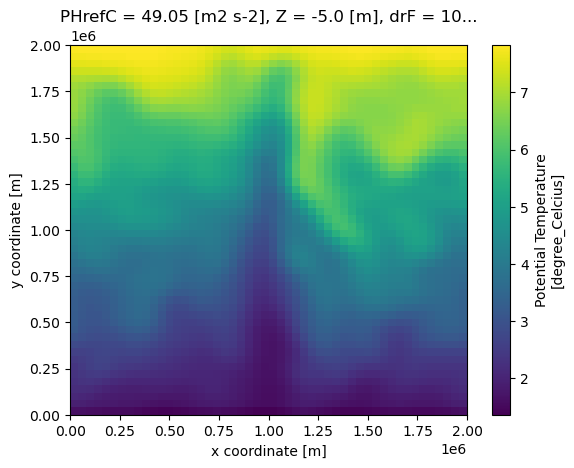

In [16]:
ds_all_res['200']['smooth_vars']['T'].isel(time=0, Z=0).plot()

In [17]:
Lkey = '200'
ds_filt_coarse = ds_all_res[Lkey]
ds_ml = xr.merge([ds_filt_coarse['smooth_vars'].to_dataset(), ds_filt_coarse['smooth_vars_grads'].to_dataset(),
                  ds_filt_coarse['SS_flux'].to_dataset(), ds_filt_coarse['SS_flux_div']['Fdiv']]) 


In [18]:
ds_ml = ds_ml.chunk({'XC':-1, 'YC':-1, 'XG':-1, 'YG':-1, 'Z':40, 'Zl': 40, 'time':1}) # choose size to make each chunk about 100mb

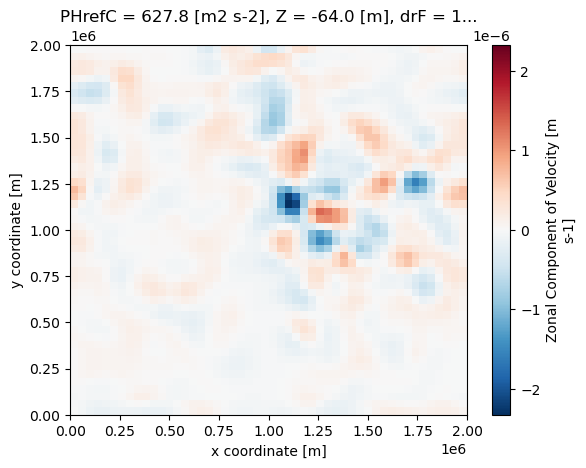

In [19]:
ds_ml['Fdiv'].isel(time=0, Z=5).plot()

In [20]:
ds_ml.nbytes/1e9

6.93368936

In [21]:
import os
SCRATCH_BUCKET = os.environ['SCRATCH_BUCKET']
PERSISTENT_BUCKET = os.environ['PERSISTENT_BUCKET']

In [22]:
import warnings
warnings.filterwarnings("ignore")

Write out things in a loop: 

In [23]:
fac = 15
len(ds_ml.time)/fac

33.0

In [24]:
len(ds_ml.time)

495

In [25]:
 # how many steps to do the process in. 
for i in range(int(len(ds_ml.time)/fac)):
    print(i)
    if i==0:
        ds_ml.isel(time=slice(i*fac,(i+1)*fac)).to_zarr(f'{PERSISTENT_BUCKET}/ML_data/ds_ML_'+Lkey+'km_3D', 
                                                  mode='w')
    else:
        ds_ml.isel(time=slice(i*fac,(i+1)*fac)).to_zarr(f'{PERSISTENT_BUCKET}/ML_data/ds_ML_'+Lkey+'km_3D', 
                                                  mode='a', append_dim='time')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32


In [26]:
Lkey

'200'

In [27]:
cluster.shutdown()

#### Try if you can open dataset

In [28]:
temp = xr.open_zarr(f'{PERSISTENT_BUCKET}/ML_data/ds_ML_'+Lkey+'km_3D')
temp

<xarray.Dataset>
Dimensions:  (YC: 50, XC: 50, time: 495, Z: 40, XG: 50, YG: 50, Zl: 40)
Coordinates: (12/24)
    Depth    (YC, XC) float32 dask.array<chunksize=(50, 50), meta=np.ndarray>
    PHrefC   (Z) float32 dask.array<chunksize=(40,), meta=np.ndarray>
  * XC       (XC) float32 2e+04 6e+04 1e+05 ... 1.9e+06 1.94e+06 1.98e+06
  * XG       (XG) float32 0.0 4e+04 8e+04 1.2e+05 ... 1.88e+06 1.92e+06 1.96e+06
  * YC       (YC) float32 2e+04 6e+04 1e+05 ... 1.9e+06 1.94e+06 1.98e+06
  * YG       (YG) float32 0.0 4e+04 8e+04 1.2e+05 ... 1.88e+06 1.92e+06 1.96e+06
    ...       ...
    maskS    (Z, YG, XC) float64 dask.array<chunksize=(40, 50, 50), meta=np.ndarray>
    maskW    (Z, YC, XG) float64 dask.array<chunksize=(40, 50, 50), meta=np.ndarray>
    rA       (YC, XC) float32 dask.array<chunksize=(50, 50), meta=np.ndarray>
    rAs      (YG, XC) float32 dask.array<chunksize=(50, 50), meta=np.ndarray>
    rAw      (YC, XG) float32 dask.array<chunksize=(50, 50), meta=np.ndarray>
  * time     (time) timedelta64[ns] 61023 days 61035 days ... 66951 days
Data variables: (12/35)
    Fdiv     (time, Z, YC, XC) float32 dask.array<chunksize=(1, 40, 50, 50), meta=np.ndarray>
    T        (time, Z, YC, XC) float32 dask.array<chunksize=(1, 40, 50, 50), meta=np.ndarray>
    T_x      (time, Z, YC, XG) float32 dask.array<chunksize=(1, 40, 50, 50), meta=np.ndarray>
    T_xx     (time, Z, YC, XC) float32 dask.array<chunksize=(1, 40, 50, 50), meta=np.ndarray>
    T_xy     (time, Z, YG, XG) float32 dask.array<chunksize=(1, 40, 50, 50), meta=np.ndarray>
    T_xz     (time, Z, YC, XG) float32 dask.array<chunksize=(1, 40, 50, 50), meta=np.ndarray>
    ...       ...
    V_z      (time, Z, YG, XC) float32 dask.array<chunksize=(1, 40, 50, 50), meta=np.ndarray>
    V_zz     (time, Z, YG, XC) float32 dask.array<chunksize=(1, 40, 50, 50), meta=np.ndarray>
    W        (time, Zl, YC, XC) float32 dask.array<chunksize=(1, 40, 50, 50), meta=np.ndarray>
    uT       (time, Z, YC, XG) float32 dask.array<chunksize=(1, 40, 50, 50), meta=np.ndarray>
    vT       (time, Z, YG, XC) float32 dask.array<chunksize=(1, 40, 50, 50), meta=np.ndarray>
    wT       (time, Zl, YC, XC) float32 dask.array<chunksize=(1, 40, 50, 50), meta=np.ndarray>

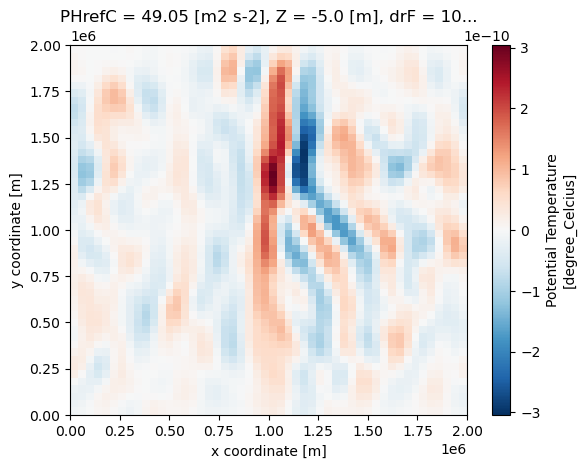

In [29]:
temp.T_xx.isel(time=0, Z=0).plot()